# PSTAT 135 Group 22: Exploratory Data Analysis

## Introduction:

The states that we chose to explore were 

## Research Questions

- How does socioeconomic background (education, income, religion, etc ) affect voter turnout?
    - How does property (household, land) ownership affect voter turnouts or patterns?
    - How does education level relate to voter alignment or patterns?
    - How would age and gender relate to voter alignment or patterns?

## Import libraries and read data

In [15]:
import seaborn as sns
import pandas as pd
import pyspark.sql.functions as F
import matplotlib.pyplot as plt

In [16]:
data = "gs://pstat135-group22/notebooks/jupyter/data/"

In [3]:
# MI - Michigan -- Swing State
mi_df = spark.read\
    .format("csv")\
    .option("header", "true")\
    .option("nullValue", "NA")\
    .option("delimiter", "\t")\
    .option("inferSchema", "true")\
    .load(data+"VM2Uniform--MI--2021-01-30/VM2Uniform--MI--2021-01-30.tab")

# SC - South Carolina -- Rep. State
sc_df = spark.read\
    .format("csv")\
    .option("header", "true")\
    .option("nullValue", "NA")\
    .option("delimiter", "\t")\
    .option("inferSchema", "true")\
    .load(data+"VM2Uniform--SC--2021-04-16/VM2Uniform--SC--2021-04-16.tab")

# MD - Maryland -- Dem State
md_df = spark.read\
    .format("csv")\
    .option("header", "true")\
    .option("nullValue", "NA")\
    .option("delimiter", "\t")\
    .option("inferSchema", "true")\
    .load(data+"VM2Uniform--MD--2021-02-15/VM2Uniform--MD--2021-02-15.tab")

In [6]:
land_cols = ["General_2020", "Voters_Age", "Voters_Gender","County", "Voters_Active",
                    "Voters_VotingPerformanceEvenYearGeneral", "ElectionReturns_G18CountyTurnoutRepublicans",
                   "ElectionReturns_G18CountyTurnoutIndependentsAllOthers", 
                   "ElectionReturns_G18CountyTurnoutDemocrats",
                   "ElectionReturns_P18CountyTurnoutAllRegisteredVoters",
                   "ElectionReturns_G16CountyTurnoutRepublicans",
                   "ElectionReturns_G16CountyTurnoutIndependentsAllOthers", 
                   "ElectionReturns_G16CountyTurnoutDemocrats",
                   "ElectionReturns_P16CountyTurnoutAllRegisteredVoters",
                   "ElectionReturns_G14CountyTurnoutRepublicans",
                   "ElectionReturns_G14CountyTurnoutIndependentsAllOthers", 
                   "ElectionReturns_G14CountyTurnoutDemocrats",
                   "ElectionReturns_P14CountyTurnoutAllRegisteredVoters",
                   "ElectionReturns_G12CountyTurnoutRepublicans",
                   "ElectionReturns_G12CountyTurnoutIndependentsAllOthers", 
                   "ElectionReturns_G12CountyTurnoutDemocrats",
                   "ElectionReturns_P12CountyTurnoutAllRegisteredVoters",
                   "Residence_Addresses_Property_LandSq_Footage",
                   "Residence_Addresses_Property_HomeSq_Footage",
                    "CommercialDataLL_Gun_Owner",
                    "CommercialDataLL_Interest_in_Religious_Inspirational_In_Household",
                    "Parties_Description"
                    
                   ]

sc_df_pd = sc_df.select(*land_cols).sample(True, 0.005, 123).toPandas()
md_df_pd = md_df.select(*land_cols).sample(True, 0.005, 123).toPandas()
mi_df_pd = mi_df.select(*land_cols).sample(True, 0.005, 123).toPandas()

sc_df_pd = sc_df_pd.sample(2000, random_state=123)
md_df_pd = md_df_pd.sample(2000, random_state=123)
mi_df_pd = mi_df_pd.sample(2000, random_state=123)

sc_df_pd["State"] = "SC"
md_df_pd["State"] = "MD"
mi_df_pd["State"] = "MI"

all_pd = sc_df_pd.append(md_df_pd).append(mi_df_pd)

all_pd['ElectionReturns_G18CountyTurnoutRepublicans'] = pd.to_numeric(all_pd['ElectionReturns_G18CountyTurnoutRepublicans'].str.replace(r'%', ''))
all_pd['ElectionReturns_G18CountyTurnoutDemocrats'] = pd.to_numeric(all_pd['ElectionReturns_G18CountyTurnoutDemocrats'].str.replace(r'%', ''))
all_pd['ElectionReturns_G16CountyTurnoutRepublicans'] = pd.to_numeric(all_pd['ElectionReturns_G16CountyTurnoutRepublicans'].str.replace(r'%', ''))
all_pd['ElectionReturns_G16CountyTurnoutDemocrats'] = pd.to_numeric(all_pd['ElectionReturns_G16CountyTurnoutDemocrats'].str.replace(r'%', ''))



23/02/20 23:07:59 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


### Property Ownership and Voter Turnout
The first idea we explored was the effect property ownership has on turnout. To do this, we selected 3 states to explore. We chose 1 swing state in Michigan, 1 Republican state in South Carolina and 1 Democratic state in Maryland. To get a better idea of the data, we first plotted the distribution of square footage.  

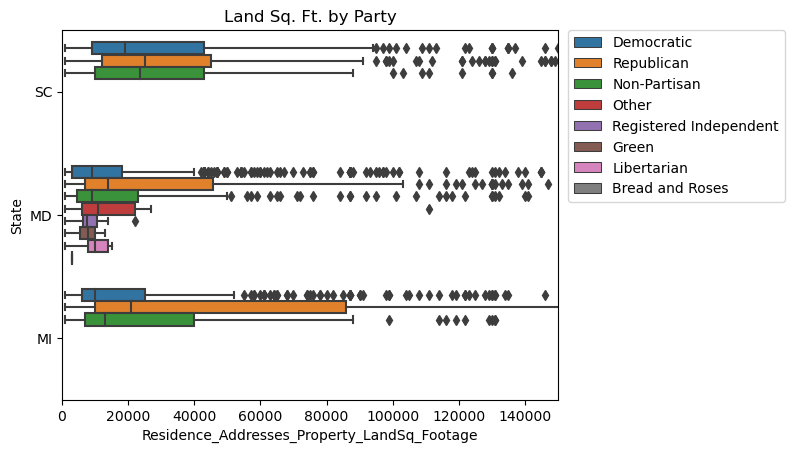

In [7]:
land_plot = sns.boxplot(data=all_pd, x="Residence_Addresses_Property_LandSq_Footage", y="State", hue="Parties_Description")
land_plot.set(title="Land Sq. Ft. by Party")
land_plot.set_xlim(0, 150000)
land_plot = plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

land_plot

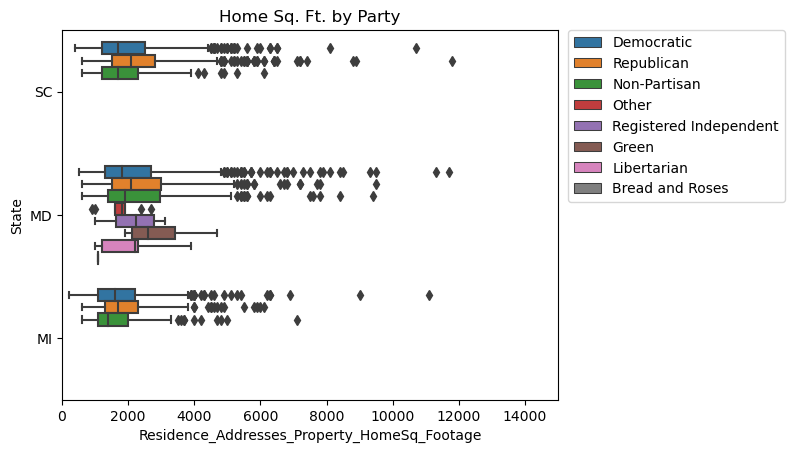

In [8]:
sqft_plot = sns.boxplot(data=all_pd, x="Residence_Addresses_Property_HomeSq_Footage", y="State", hue="Parties_Description")
sqft_plot.set(title="Home Sq. Ft. by Party")
sqft_plot.set_xlim(0, 15000)
sqft_plot = plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

sqft_plot

These initial plots shows us that republicans tend to have more land and larger houses but how does voter turnout look in these states? Does it appear to be correlated?

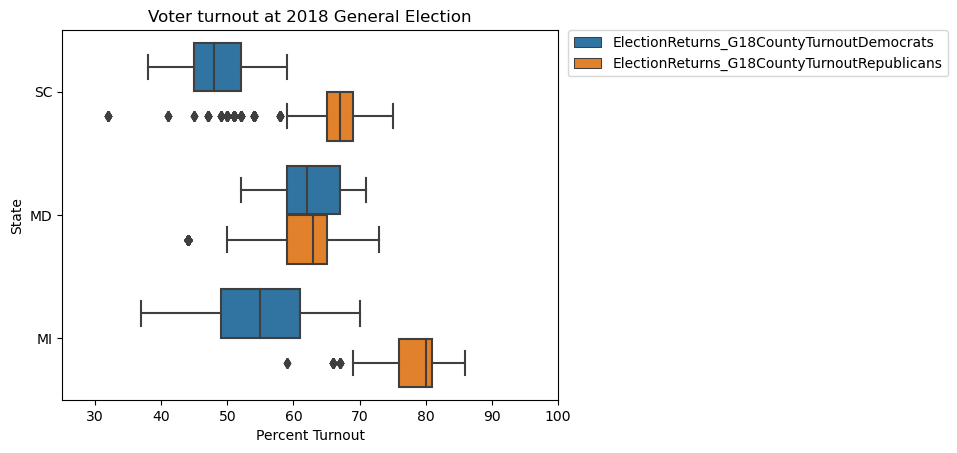

In [10]:
turnout_2018 = all_pd[["ElectionReturns_G18CountyTurnoutDemocrats", "ElectionReturns_G18CountyTurnoutRepublicans", "State"]]
turnout_2018 = pd.melt(turnout_2018, id_vars="State", value_vars=["ElectionReturns_G18CountyTurnoutDemocrats", "ElectionReturns_G18CountyTurnoutRepublicans"])

turnout_2018_plot = sns.boxplot(data=turnout_2018, x="value", y="State", hue="variable")
turnout_2018_plot.set(title="Voter turnout at 2018 General Election", xlabel="Percent Turnout")
turnout_2018_plot.set_xlim(25,100)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

Of these states, Michigan (a swing state) had the largest different in turnout between parties. We can also see that Michigan's distribution of Land Square Footage also has the largest different between parties. From these visualziations, it appears that land square footage plays a role in voter turnout. 


#### Difference in Presidential Election Years
The year we looked at was 2018 so there was a midterm election. Does this trend hold for years where there is a presidential election?


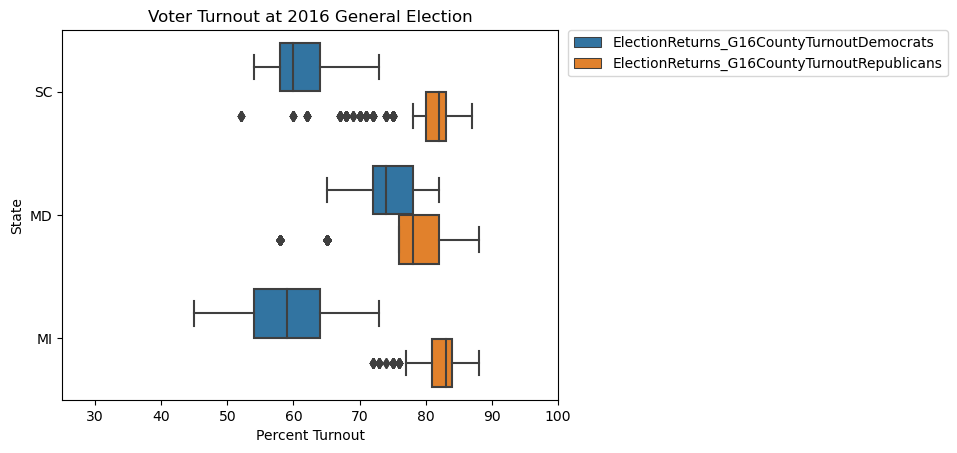

In [11]:
turnout_2016 = all_pd[["ElectionReturns_G16CountyTurnoutDemocrats", "ElectionReturns_G16CountyTurnoutRepublicans", "State"]]
turnout_2016 = pd.melt(turnout_2016, id_vars="State", value_vars=["ElectionReturns_G16CountyTurnoutDemocrats", "ElectionReturns_G16CountyTurnoutRepublicans"])

turnout_2016_plot = sns.boxplot(data=turnout_2016, x="value", y="State", hue="variable")
turnout_2016_plot.set(title="Voter Turnout at 2016 General Election", xlabel="Percent Turnout")
turnout_2016_plot.set_xlim(25,100)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

This trend seems to hold in presidential elections. A secondary observation is that the swing state Michigan sees relatively similar turnout at each election while the other states saw a sizeable increase of about 10-15% in voter turnout. At least from these states, it seems that voter turnout is generally more consistent in swing states. 

## Florida EDA, Swing State

In [1]:
# load in data
df_fl = spark.read\
    .format("csv")\
    .option("header", "true")\
    .option("nullValue", "NA")\
    .option("delimiter", "\t")\
    .option("inferSchema", "true")\
    .load("gs://pstat135-group22/notebooks/jupyter/data/VM2Uniform--FL--2021-05-19/VM2Uniform--FL--2021-05-19.tab")

### Sample
Lets consider small samples of some interesting variables to make it easier to explore. Consider the two most recent Presidential Elections for now.

# First lets pull out columns of interest
interest_cols = [ "General_2020", "General_2016","General_2018", "PresidentialPrimary_2020","PresidentialPrimary_2016",
                 "Voters_Age", "Voters_Gender", "County", "CountyEthnic_Description", "Voters_Active",
                   "Voters_VotingPerformanceEvenYearGeneral", 
                   "ElectionReturns_G18CountyTurnoutRepublicans",
                   "ElectionReturns_G18CountyTurnoutIndependentsAllOthers", 
                   "ElectionReturns_G18CountyTurnoutDemocrats",
                   "ElectionReturns_P18CountyTurnoutAllRegisteredVoters",
                   "ElectionReturns_G16CountyTurnoutRepublicans",
                   "ElectionReturns_G16CountyTurnoutIndependentsAllOthers", 
                   "ElectionReturns_G16CountyTurnoutDemocrats",
                   "ElectionReturns_P16CountyTurnoutAllRegisteredVoters",
                   "Residence_Addresses_Property_LandSq_Footage",
                   "Residence_Addresses_Property_HomeSq_Footage",
                   "Parties_Description", 
                   "VoterParties_Change_Changed_Party",
                   "CommercialData_EstimatedHHIncome",
                   "CommercialData_AreaMedianEducationYears",
                   "CommercialDataLL_Household_Primary_Language",
                 "CommercialDataLL_Business_Owner"                              
]

In [4]:
# sample of the data
df_fl_pd = df_fl.select(*interest_cols).sample(True, 0.005, 123).toPandas()

23/02/21 02:12:12 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [12]:
# take out a sample of 2000 to have faster runtimes
df_fl_pd = df_fl_pd.sample(2000, random_state=123)

df_fl_pd.head()

df_fl_pd["State"] = "FL"

NameError: name 'df_fl_pd' is not defined

### Age and Gender Plots

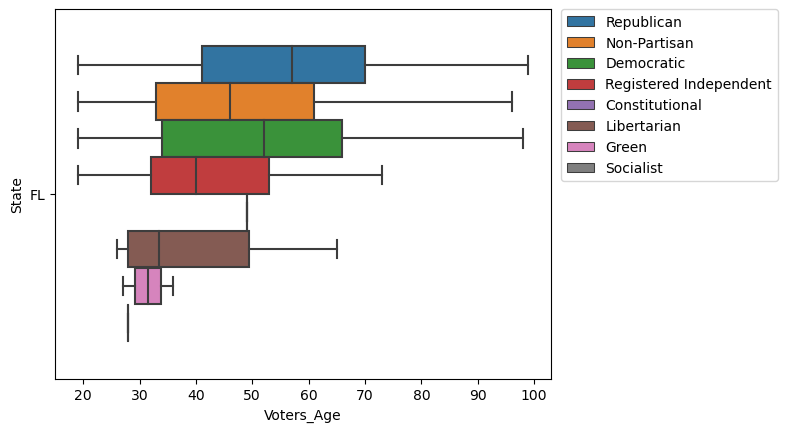

In [8]:
# age

ageplot_fl = sns.boxplot(data=df_fl_pd, x="Voters_Age", y="State",hue="Parties_Description")
ageplot_fl = plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
ageplot_fl

# The median Republican age is the greatest
# and for Green/Socialist its the lowest, but bear in mind we are looking at only 2000 obs

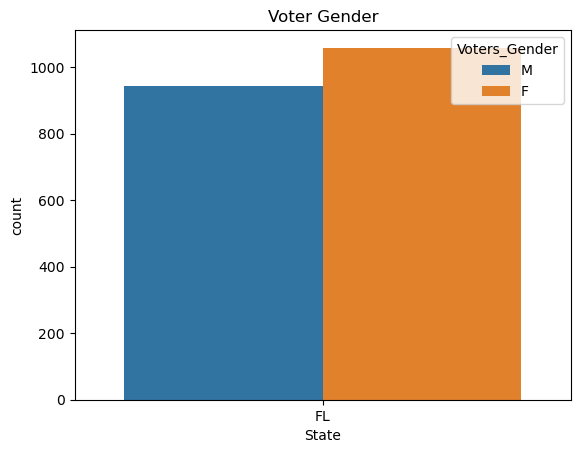

In [9]:
# gender
gender_chart_fl = sns.countplot(data=df_fl_pd, x="State",
                             hue="Voters_Gender").set(title="Voter Gender")

# there are more female voters in the sample

### Property Ownership

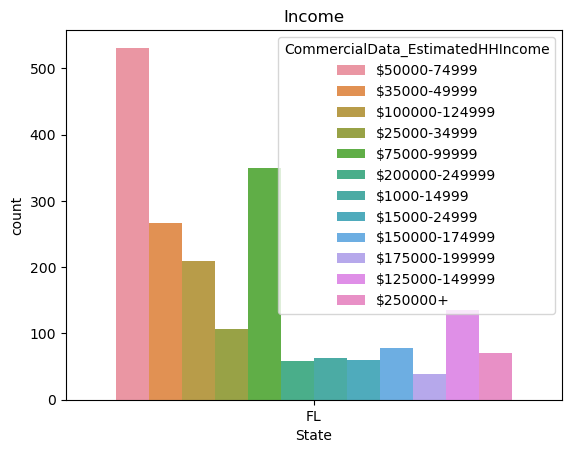

In [10]:
# income
income_chart_fl = sns.countplot(data=df_fl_pd, x="State",
                             hue="CommercialData_EstimatedHHIncome").set(title="Income")

# This income chart distribution is very interesting, the spread is a bit unexpected, (personally I expected more rich voters)
# but this is likely becuase there is a smaller population of wealthy voters 

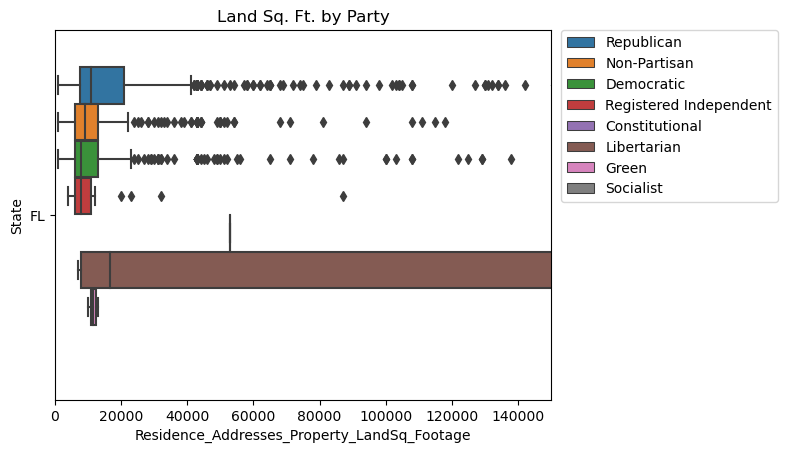

In [11]:
land_plot_fl = sns.boxplot(data=df_fl_pd, x="Residence_Addresses_Property_LandSq_Footage", y="State", hue="Parties_Description")
land_plot_fl.set(title="Land Sq. Ft. by Party")
land_plot_fl.set_xlim(0, 150000)
land_plot_fl = plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

land_plot_fl

# this specific plot doesnt seem that right, likely due to small sample we are looking at
# but we can leave these plot here for now to generalize later, or maybe increase the sample size a little
# there could be a input errors in Libtertairan as well, or maybe they just live on huge land

In [ ]:
# consider the house sq ft itself
sqft_plot_fl = sns.boxplot(data=df_fl_pd, x="Residence_Addresses_Property_HomeSq_Footage", y="State", hue="Parties_Description")
sqft_plot_fl.set(title="Home Sq. Ft. by Party")
sqft_plot_fl.set_xlim(0, 15000)
sqft_plot_fl = plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

sqft_plot_fl

# so to relate to the previous plot, likely they just have a huge piece of land bc we do not see the huge 
# box for libertarian again

### Education

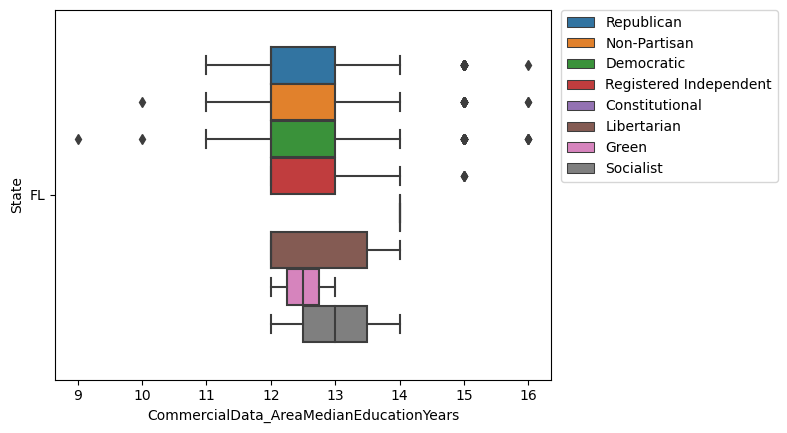

In [13]:
# education
eduplot_fl = sns.boxplot(data=df_fl_pd, x="CommercialData_AreaMedianEducationYears", y="State", hue="Parties_Description")
eduplot_fl = plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
eduplot_fl
# there isnt much difference here in the median years of education, and is about expected
# the outliers here make sense too, that highly educated people would likely be aligned with the main parties
# or this may be due to a greater amt of people in the main parties regardless of education

## Party and Voter Turnout
Let's briefly look at party distribution and voter turn out for select elections in Florida.

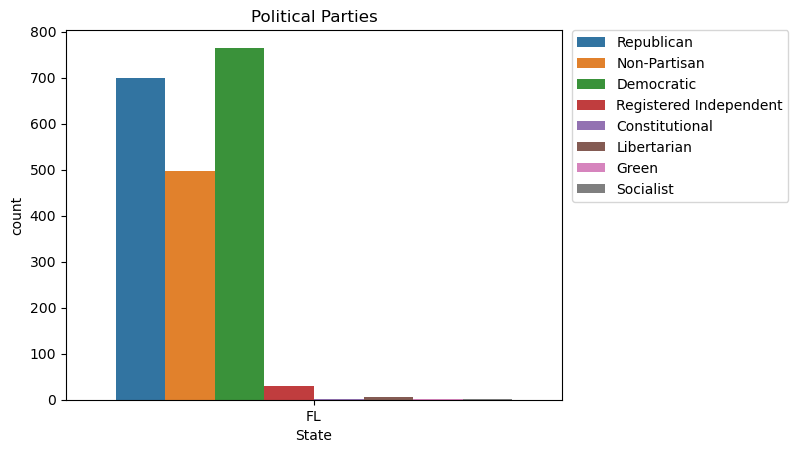

In [14]:
party_chart_fl = sns.countplot(data=df_fl_pd, x="State",
                             hue="Parties_Description").set(title="Political Parties")
party_chart_fl = plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

party_chart_fl

In [15]:
turnout_2016_fl = df_fl_pd[["ElectionReturns_G16CountyTurnoutDemocrats", "ElectionReturns_G16CountyTurnoutRepublicans", "State"]]

turnout_2016_fl.loc[:, ["ElectionReturns_G16CountyTurnoutDemocrats","ElectionReturns_G16CountyTurnoutRepublicans"]] = (turnout_2016_fl
 .loc[:, ["ElectionReturns_G16CountyTurnoutDemocrats","ElectionReturns_G16CountyTurnoutRepublicans"]]
 .replace(r"%","", regex=True)
 .apply(pd.to_numeric, errors="coerce")
)

turnout_2016_fl = pd.melt(turnout_2016_fl, id_vars="State", value_vars=["ElectionReturns_G16CountyTurnoutDemocrats", "ElectionReturns_G16CountyTurnoutRepublicans"])
turnout_2016_fl.head()

/opt/conda/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/conda/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


,State,variable,value
0,FL,ElectionReturns_G16CountyTurnoutDemocrats,72
1,FL,ElectionReturns_G16CountyTurnoutDemocrats,74
2,FL,ElectionReturns_G16CountyTurnoutDemocrats,74
3,FL,ElectionReturns_G16CountyTurnoutDemocrats,69
4,FL,ElectionReturns_G16CountyTurnoutDemocrats,80


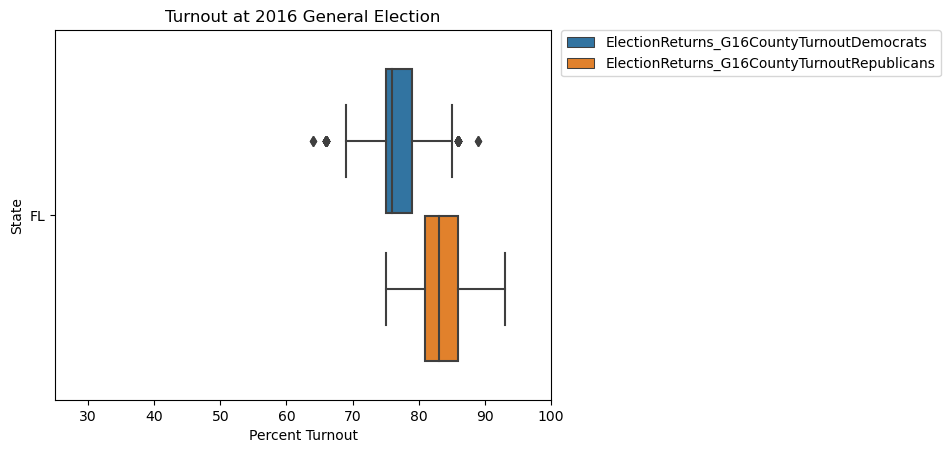

In [16]:
turnout_2016_plot_fl = sns.boxplot(data=turnout_2016_fl, x="value", y= "State", hue="variable")
turnout_2016_plot_fl.set(title="Turnout at 2016 General Election", xlabel="Percent Turnout")
turnout_2016_plot_fl.set_xlim(25,100)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [17]:
turnout_2018_fl = df_fl_pd[["ElectionReturns_G18CountyTurnoutDemocrats", "ElectionReturns_G18CountyTurnoutRepublicans", "State"]]

turnout_2018_fl.loc[:, ["ElectionReturns_G18CountyTurnoutDemocrats","ElectionReturns_G18CountyTurnoutRepublicans"]] = (turnout_2018_fl
 .loc[:, ["ElectionReturns_G18CountyTurnoutDemocrats","ElectionReturns_G18CountyTurnoutRepublicans"]]
 .replace(r"%","", regex=True)
 .apply(pd.to_numeric, errors="coerce")
)

turnout_2018_fl = pd.melt(turnout_2018_fl, id_vars="State", value_vars=["ElectionReturns_G18CountyTurnoutDemocrats", "ElectionReturns_G18CountyTurnoutRepublicans"])
turnout_2018_fl.head()

/opt/conda/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/conda/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


,State,variable,value
0,FL,ElectionReturns_G18CountyTurnoutDemocrats,59
1,FL,ElectionReturns_G18CountyTurnoutDemocrats,63
2,FL,ElectionReturns_G18CountyTurnoutDemocrats,63
3,FL,ElectionReturns_G18CountyTurnoutDemocrats,62
4,FL,ElectionReturns_G18CountyTurnoutDemocrats,71


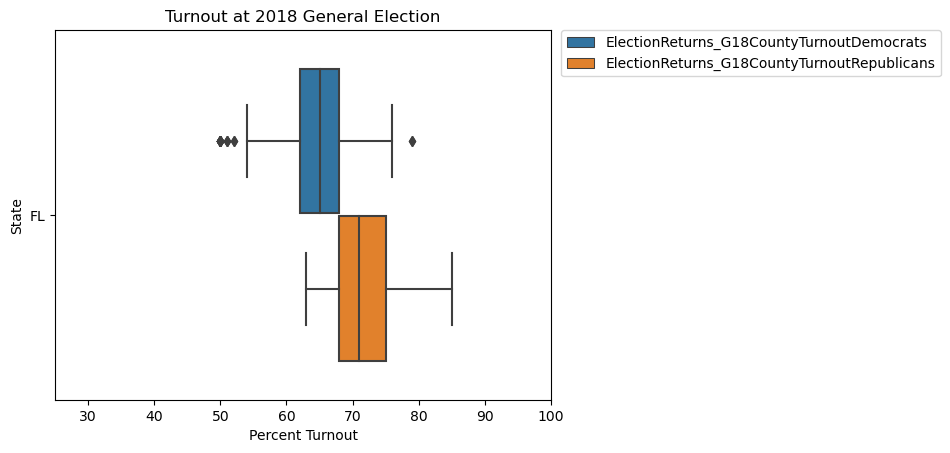

In [18]:
turnout_2018_plot_fl = sns.boxplot(data=turnout_2018_fl, x="value", y= "State", hue="variable")
turnout_2018_plot_fl.set(title="Turnout at 2018 General Election", xlabel="Percent Turnout")
turnout_2018_plot_fl.set_xlim(25,100)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

Between these two years, voter turnout decreased by around 10 percent for both parties, which is pretty suprising as only 2 years passed.

# Arizona EDA

In [17]:
az_df = spark.read\
    .format("csv")\
    .option("header", "true")\
    .option("nullValue", "NA")\
    .option("delimiter", "\t")\
    .option("inferSchema", "true")\
    .load(data+"VM2Uniform--AZ--2021-05-20/VM2Uniform--AZ--2021-05-20.tab")

In [102]:
selected_interest = [ "General_2020", "General_2016","General_2018", "PresidentialPrimary_2020","PresidentialPrimary_2016",
                 "Voters_Age", "Voters_Gender", "County", "CountyEthnic_Description", "Voters_Active", "CommercialData_EstimatedHHIncomeAmount",
                   "Voters_VotingPerformanceEvenYearGeneral", 
                   "ElectionReturns_G18CountyTurnoutRepublicans",
                   "ElectionReturns_G18CountyTurnoutIndependentsAllOthers", 
                   "ElectionReturns_G18CountyTurnoutDemocrats",
                   "ElectionReturns_P18CountyTurnoutAllRegisteredVoters",
                   "ElectionReturns_G16CountyTurnoutRepublicans",
                   "ElectionReturns_G16CountyTurnoutIndependentsAllOthers", 
                   "ElectionReturns_G16CountyTurnoutDemocrats",
                   "ElectionReturns_P16CountyTurnoutAllRegisteredVoters",
                   "Residence_Addresses_Property_LandSq_Footage",
                   "Residence_Addresses_Property_HomeSq_Footage",
                   "Parties_Description", 
                   "VoterParties_Change_Changed_Party",
                   "CommercialData_EstimatedHHIncome",
                   "CommercialData_AreaMedianEducationYears",
                   "CommercialDataLL_Household_Primary_Language",
                 "CommercialDataLL_Business_Owner",
                     "CommercialData_EstimatedAreaMedianHHIncome"
]

In [96]:
az_df_pd = az_df.select(*selected_interest).sample(True, 0.005, 123).toPandas()
az_df_pd = az_df_pd.sample(2000, random_state=123)
az_df_pd["State"] = "AZ"

In [125]:
az_df_pd['ElectionReturns_G18CountyTurnoutRepublicans'] = pd.to_numeric(az_df_pd['ElectionReturns_G18CountyTurnoutRepublicans'].str.replace(r'%', ''))
az_df_pd['ElectionReturns_G18CountyTurnoutDemocrats'] = pd.to_numeric(az_df_pd['ElectionReturns_G18CountyTurnoutDemocrats'].str.replace(r'%', ''))
az_df_pd['ElectionReturns_G16CountyTurnoutRepublicans'] = pd.to_numeric(az_df_pd['ElectionReturns_G16CountyTurnoutRepublicans'].str.replace(r'%', ''))
az_df_pd['ElectionReturns_G16CountyTurnoutDemocrats'] = pd.to_numeric(az_df_pd['ElectionReturns_G16CountyTurnoutDemocrats'].str.replace(r'%', ''))

AttributeError: Can only use .str accessor with string values!

### Property Ownership

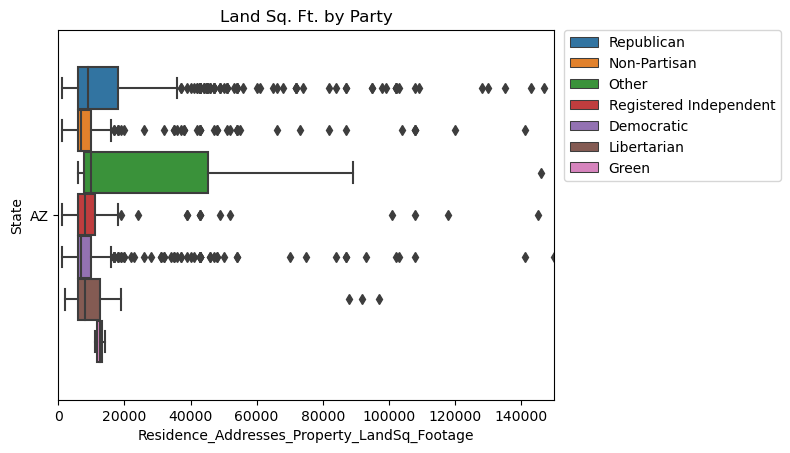

In [103]:
land_plot_az = sns.boxplot(data=az_df_pd, x="Residence_Addresses_Property_LandSq_Footage", y="State", hue="Parties_Description")
land_plot_az.set(title="Land Sq. Ft. by Party")
land_plot_az.set_xlim(0, 150000)
land_plot_az = plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

land_plot_az

# 'Other' voters tend to have the most land
# However, lots of republican outliers favor more land

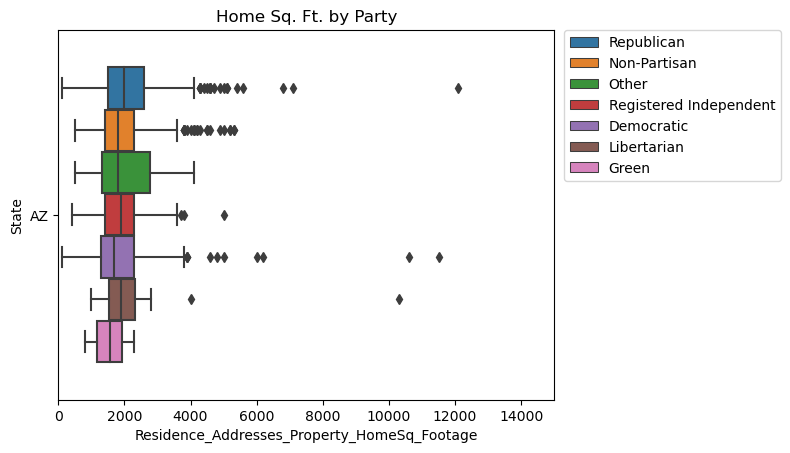

In [104]:
sqft_plot = sns.boxplot(data=az_df_pd, x="Residence_Addresses_Property_HomeSq_Footage", y="State", hue="Parties_Description")
sqft_plot.set(title="Home Sq. Ft. by Party")
sqft_plot.set_xlim(0, 15000)
sqft_plot = plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

sqft_plot

# We can also see that republicans and 'other' tend to have the largest homes, by looking at their corresponding medians
# There are also lots of outliers for republican and non-partisan that favor larger homes

### Voter Turnout

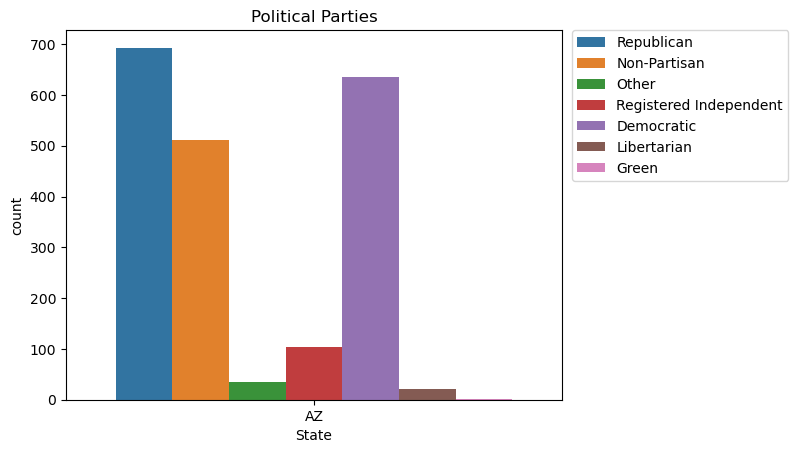

In [133]:
party_chart_az = sns.countplot(data=az_df_pd, x="State",
                             hue="Parties_Description").set(title="Political Parties")
party_chart_az = plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
party_chart_az
# From our sample, republicans made up the highest vote, democrats second, and non-partisan third.
# Which makes sense given we are looking at Arizona, a swing state

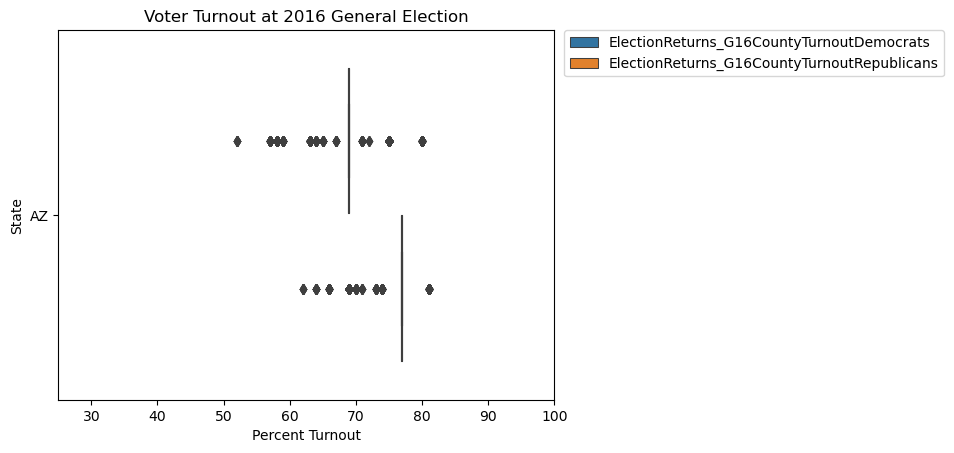

In [105]:
turnout_2016_az = az_df_pd[["ElectionReturns_G16CountyTurnoutDemocrats", "ElectionReturns_G16CountyTurnoutRepublicans", "State"]]
turnout_2016_az = pd.melt(turnout_2016_az, id_vars="State", value_vars=["ElectionReturns_G16CountyTurnoutDemocrats", "ElectionReturns_G16CountyTurnoutRepublicans"])

turnout_2016_plot_az = sns.boxplot(data=turnout_2016_az, x="value", y="State", hue="variable")
turnout_2016_plot_az.set(title="Voter Turnout at 2016 General Election", xlabel="Percent Turnout")
turnout_2016_plot_az.set_xlim(25,100)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

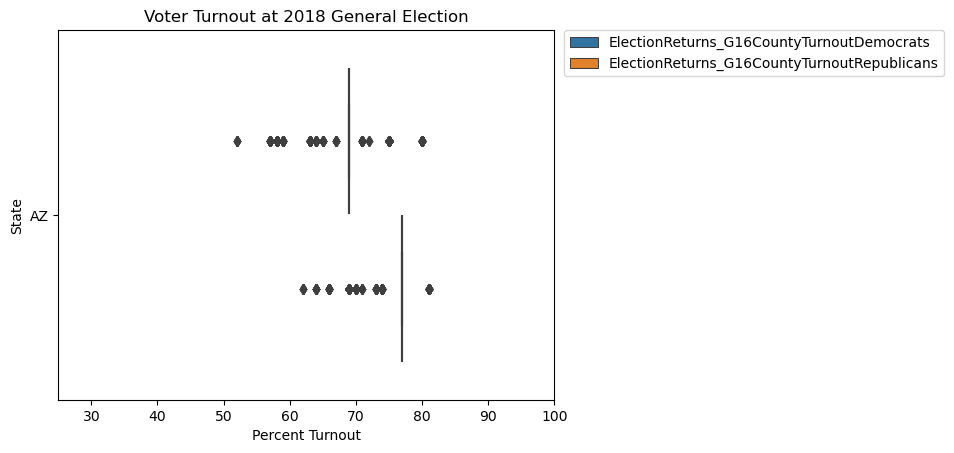

In [106]:
turnout_2018_az = az_df_pd[["ElectionReturns_G18CountyTurnoutDemocrats", "ElectionReturns_G18CountyTurnoutRepublicans", "State"]]
turnout_2018_az = pd.melt(turnout_2018_az, id_vars="State", value_vars=["ElectionReturns_G18CountyTurnoutDemocrats", "ElectionReturns_G18CountyTurnoutRepublicans"])

turnout_2018_plot_az = sns.boxplot(data=turnout_2016_az, x="value", y="State", hue="variable")
turnout_2018_plot_az.set(title="Voter Turnout at 2018 General Election", xlabel="Percent Turnout")
turnout_2018_plot_az.set_xlim(25,100)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

##### From our sample, we can see that the voter turnout from 2016 to 2018 was relatively the same. 

### Age & Gender

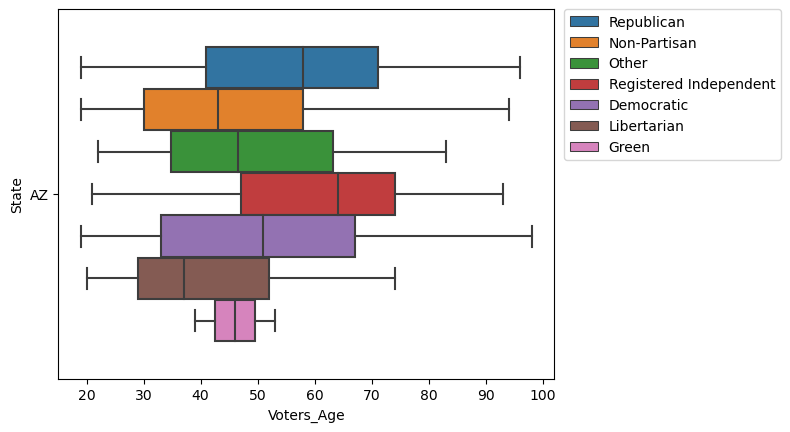

In [127]:
age_az = sns.boxplot(data=az_df_pd, x="Voters_Age", y="State",hue="Parties_Description")
age_az = plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
age_az

# From our sample, registered independents, republicans, and democrats are the top 3 in terms of median age, in that specific order.

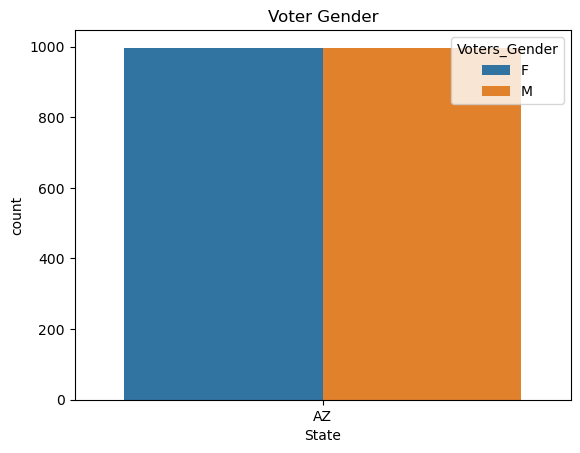

In [108]:
gender_chart_az = sns.countplot(data=az_df_pd, x="State",
                             hue="Voters_Gender").set(title="Voter Gender")

# From our sample, the gender of the voter was even.

### Education

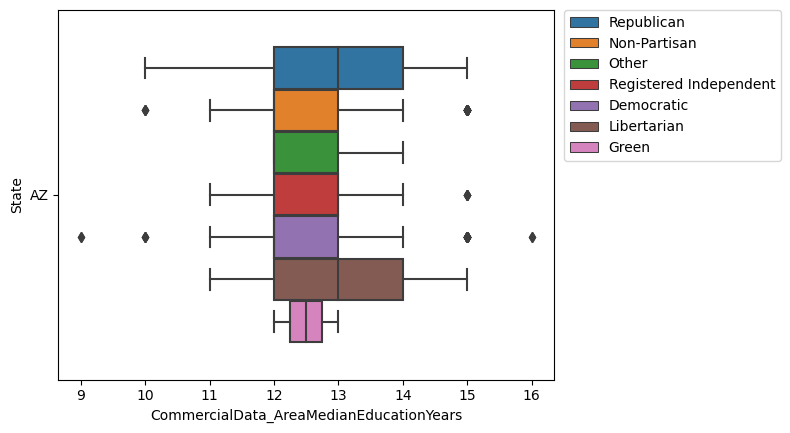

In [128]:
edu_az = sns.boxplot(data=az_df_pd, x="CommercialData_AreaMedianEducationYears", y="State", hue="Parties_Description")
edu_az = plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
edu_az

# From our sample, republicans and libertarians leaned more towards a higher number of median education years, but the parties were relatively the same throughout.

### Income

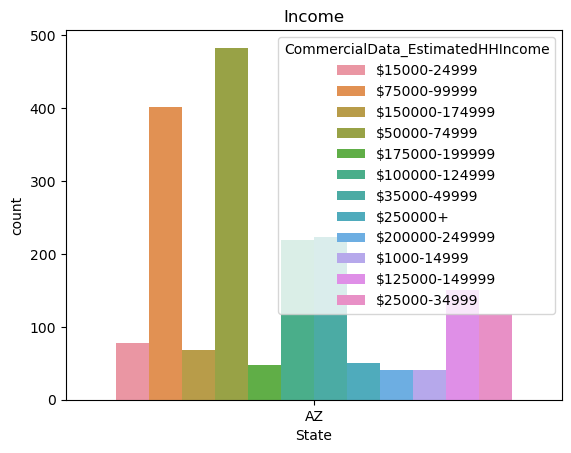

In [132]:
income_chart_az = sns.countplot(data=az_df_pd, x="State",
                             hue="CommercialData_EstimatedHHIncome").set(title="Income")

# From our sample, we can see that most voters turned out to be those whose income falls in the category of 'middle-class'
# This makes sense since the majority of adults in American make up the middle-class in terms of income.